In [1]:
# necessary imports
import matplotlib.pyplot as plt # for plotting
import numpy as np # for transformation

import torch
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
import torch.nn as nn # basic building block for neural networks
import torch.nn.functional as F # import functions like Relu
import torch.optim as optim # optimizer
import torchvision.datasets as datasets

print("Using torch", torch.__version__)

Using torch 2.3.0+cu121


In [2]:
torch.manual_seed(26)

#### Classification for CIFAR-100

##### Load the dataset from torchvision

In [3]:
transform = transforms.Compose(
# composing several transforms together
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

batch_size = 256
num_workers = 2

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                         download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)

100%|██████████| 169001437/169001437 [00:05<00:00, 30620428.01it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


#### Convolutional Neural Network (CNN)

Initial network design, base network

In [4]:
d_in = 3  # Input channels (RGB images)
d_out = 100  # Number of classes in CIFAR100
activation_fn = nn.ReLU()

In [5]:
class ConvNetDA520(nn.Module):
  def __init__(self):
    super(ConvNetDA520, self).__init__()
    # Define the layers of your neural network
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(64 * 4 * 4, 256)
    self.fc2 = nn.Linear(256, 100)  # Output layer for 100 classes

  def forward(self, x):
    # Define the forward pass of your neural network
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = self.pool3(F.relu(self.conv3(x)))
    x = x.view(-1, 64 * 4 * 4)  # Flatten the tensor for the fully connected layer
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

model = ConvNetDA520()

print(model)

ConvNetDA520(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=100, bias=True)
)


##### Create and Train CNN Model

In [6]:
n_epoch = 200
model = ConvNetDA520()

# Function to initialize model weights
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

# Initialize model weights
model.apply(weights_init)
loss_fn = nn.CrossEntropyLoss()  # Suitable for classification tasks with multiple classes
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer

In [13]:
def train(epoch):
    model.train()  # Set the model to training mode
    train_loss = 0
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to('cuda'), target.to('cuda')
        optimizer.zero_grad()  # Reset gradients
        output = model(data)  # Forward pass
        loss = loss_fn(output, target)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters
        train_loss += loss.item()  # Sum up batch loss
    train_loss /= len(trainloader)  # Average the loss over the number of batches
    train_losses.append(train_loss)
    print(f'Epoch {epoch}, Training Loss: {train_loss:.4f}')

In [17]:
#Test the model
def test():
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to('cuda'), target.to('cuda')
            output = model(data)
            test_loss += loss_fn(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()  # Count correct predictions
            # Average the loss over the number of batches
    test_loss /= len(testloader)
    test_losses.append(test_loss)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(testloader.dataset)} ({100. * correct / len(testloader.dataset):.2f}%)')

In [130]:
# Train and test the model
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Learning rate scheduler

for epoch in range(1, n_epoch + 1):
    train(epoch)
    test()
    scheduler.step()

Epoch: 1, Batch: 0, Loss: 2.3373680114746094
Epoch: 1, Batch: 100, Loss: 2.7677581310272217
Epoch: 1, Batch: 200, Loss: 2.557374954223633
Epoch: 1, Batch: 300, Loss: 2.916543483734131
Epoch: 1, Batch: 400, Loss: 2.944985866546631
Epoch: 1, Batch: 500, Loss: 2.6073224544525146
Epoch: 1, Batch: 600, Loss: 2.77018141746521
Epoch: 1, Batch: 700, Loss: 2.790825843811035
Epoch: 1, Batch: 800, Loss: 1.9067667722702026
Epoch: 1, Batch: 900, Loss: 2.0743439197540283
Epoch: 1, Batch: 1000, Loss: 2.10469651222229
Epoch: 1, Batch: 1100, Loss: 2.5405633449554443
Epoch: 1, Batch: 1200, Loss: 2.504849433898926
Epoch: 1, Batch: 1300, Loss: 2.6175758838653564
Epoch: 1, Batch: 1400, Loss: 2.0971932411193848
Epoch: 1, Batch: 1500, Loss: 2.3966684341430664
Epoch 1 complete, Average Loss: 2.484972962643653
Test set: Average loss: 0.0791, Accuracy: 3615/10000 (36.15%)
Epoch: 2, Batch: 0, Loss: 2.1904184818267822
Epoch: 2, Batch: 100, Loss: 1.8324291706085205
Epoch: 2, Batch: 200, Loss: 1.7541518211364746
Ep

KeyboardInterrupt: 

##### Experiment with Hyperparameters and Architectures

Parameter grid and used for loops to experiment with different hyperparameters programmatically.

In [26]:
from sklearn.model_selection import ParameterGrid

# Define the parameter grid
param_grid = {
    'lr': [0.1, 0.01, 0.001, 0.005],
    'batch_size': [64, 128, 256],
    'optimizer': ['Adam', 'SGD', 'RMSprop']
}

# Create a list of hyperparameter combinations
grid = list(ParameterGrid(param_grid))

# Function to train and evaluate the model with given hyperparameters
def train_and_evaluate(lr, batch_size, optimizer_name):
    # Update dataloader with the new batch size
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    # Define the model, loss function, and optimizer
    model = ConvNetDA520().to('cuda')
    loss_fn = nn.CrossEntropyLoss()

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    # Training loop
    for epoch in range(1, 200):
        model.train()
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(trainloader):
            data, target = data.to('cuda'), target.to('cuda')
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch}, Loss: {running_loss / len(trainloader)}')

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to('cuda'), target.to('cuda')
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * (correct / total)
    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy

# Iterate over all combinations in the grid
best_accuracy = 0
best_params = None
for params in grid:
    print(f"Training with params: {params}")
    accuracy = train_and_evaluate(params['lr'], params['batch_size'], params['optimizer'])
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

print(f"Best Accuracy: {best_accuracy:.2f}% with params: {best_params}")

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Epoch 26, Loss: 2.403191789489268
Epoch 27, Loss: 2.3959359997678598
Epoch 28, Loss: 2.39312101355599
Epoch 29, Loss: 2.383316360623635
Epoch 30, Loss: 2.3934703457081103
Epoch 31, Loss: 2.3824440236286737
Epoch 32, Loss: 2.379054815110648
Epoch 33, Loss: 2.3878768754127386
Epoch 34, Loss: 2.380481389020105
Epoch 35, Loss: 2.3862892008193617
Epoch 36, Loss: 2.3759565046986046
Epoch 37, Loss: 2.3887488726154924
Epoch 38, Loss: 2.381001355855361
Epoch 39, Loss: 2.3836162693970038
Epoch 40, Loss: 2.395454063744801
Epoch 41, Loss: 2.3861158519144863
Epoch 42, Loss: 2.4064861151873305
Epoch 43, Loss: 2.3969866270604343
Epoch 44, Loss: 2.405819177475122
Epoch 45, Loss: 2.4262562331641115
Epoch 46, Loss: 2.405751840690213
Epoch 47, Loss: 2.416478221983556
Epoch 48, Loss: 2.433315477102919
Epoch 49, Loss: 2.4227990724546524
Epoch 50, Loss: 2.4300280990807908
Epoch 51, Loss: 2.4353068557846576
Epoch 52, Loss: 2.4225086330452843
Epoch 53, Loss: 2.45

Initial metrics were:

*   Test set: Average loss: 0.3984, Accuracy: 3514/10000 (35.14%)

After the parameter tuning:



1. Best Accuracy: 36.68% with params: {'batch_size': 256, 'lr': 0.1,'optimizer': 'SGD'}




In [9]:
# New Hyperparameters
n_epoch = 200
model = ConvNetDA520()
model.apply(weights_init)
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

## Changelist for ConvNetDA520_20

The whole update process was iterative and the final network I come up with is the one below. Here are the changes made.


---



> **I am are aware that using the hyperparameters from the previous network is sub-optimal but I had to move on with the hyperparams we found for the previous network due to computational time cost and time limitations.**




---


- **Increased Convolutional Filters**:
  - Conv1: Increased from 16 to 256
  - Conv2: Increased from 32 to 256
  - Added Conv3, Conv4, Conv5, Conv6, Conv7, Conv8 with 512 filters each

- **Added Batch Normalization Layers**:
  - After each convolutional layer (8 BatchNorm2d layers added)

- **Modified Pooling Layers**:
  - Added an additional pooling layer (4 MaxPool2d layers in total)

- **Increased Dropout Regularization**:
  - Added dropout after each pooling layer and before the fully connected layer (5 Dropout layers in total)

- **Updated Fully Connected Layers**:
  - Changed input dimension of fc1 to match new flattened size (512 * 2 * 2)
  - Increased size of fc1 from 256 to 1024
  - Added BatchNorm1d layer after fc1

- **Adjusted Model Architecture**:
  - Changed the forward pass to include the new layers and operations


In [10]:
class ConvNetDA520_20(nn.Module):
    def __init__(self):
        # Initial image was 32 X 32 X 3
        super(ConvNetDA520_20, self).__init__()
        self.conv1 = nn.Conv2d(3, 256, 3, padding=1) # 32 X 32 X 256
        self.bn1 = nn.BatchNorm2d(256) # 32 X 32 X 256
        self.conv2 = nn.Conv2d(256, 256, 3, padding=1) # 32 X 32 X 256
        self.bn2 = nn.BatchNorm2d(256) # 32 X 32 X 256
        self.pool1 = nn.MaxPool2d(2, 2) # 16 X 16 X 256
        self.dropout1 = nn.Dropout(0.2) # 16 X 16 X 256

        self.conv3 = nn.Conv2d(256, 512, 3, padding=1) # 16 X 16 X 512
        self.bn3 = nn.BatchNorm2d(512) # 16 X 16 X 512
        self.conv4 = nn.Conv2d(512, 512, 3, padding=1) # 16 X 16 X 512
        self.bn4 = nn.BatchNorm2d(512) # 16 X 16 X 512
        self.pool2 = nn.MaxPool2d(2, 2) # 8 X 8 X 512
        self.dropout2 = nn.Dropout(0.2) # 8 X 8 X 512

        self.conv5 = nn.Conv2d(512, 512, 3, padding=1) # 8 X 8 X 512
        self.bn5 = nn.BatchNorm2d(512) # 8 X 8 X 512
        self.conv6 = nn.Conv2d(512, 512, 3, padding=1) # 8 X 8 X 512
        self.bn6 = nn.BatchNorm2d(512) # 8 X 8 X 512
        self.pool3 = nn.MaxPool2d(2, 2) # 4 X 4 X 512
        self.dropout3 = nn.Dropout(0.2) # 4 X 4 X 512

        self.conv7 = nn.Conv2d(512, 512, 3, padding=1) # 4 X 4 X 512
        self.bn7 = nn.BatchNorm2d(512) # 4 X 4 X 512
        self.conv8 = nn.Conv2d(512, 512, 3, padding=1) # 4 X 4 X 512
        self.bn8 = nn.BatchNorm2d(512) # 4 X 4 X 512
        self.pool4 = nn.MaxPool2d(2, 2) # 2 X 2 X 512
        self.dropout4 = nn.Dropout(0.2) # 2 X 2 X 512

        self.flatten = nn.Flatten() # 1 X 2048
        self.fc1 = nn.Linear(512 * 2 * 2, 1024) # 1 X 1024
        self.dropout5 = nn.Dropout(0.2) # 1 X 1024
        self.bn9 = nn.BatchNorm1d(1024, momentum=0.95, eps=0.005) # 1 X 1024
        self.fc2 = nn.Linear(1024, 100) # 1 X 1024

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.pool4(x)
        x = self.dropout4(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout5(x)
        x = self.bn9(x)
        x = self.fc2(x)
        return x

In [20]:
# use different convolutional and pooling layer configurations
n_epoch = 200
model = ConvNetDA520_20()
model.to('cuda')
# Initialize model weights
model.apply(weights_init)
# loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=learning_rate,  weight_decay=1e-4) # Added L2 Regularization


According to the previous experiments our final run hyperparameters are below

*   Batch size = 256
*   Model is on the cuda
*   Epoch is 200
*   Learning rate is 0.1
*   Optimizer is SGD






In [21]:
train_losses = []
test_losses = []

#Train and test the new model
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Learning rate scheduler

for epoch in range(1, n_epoch + 1):
    train(epoch)
    test()
    scheduler.step()

Epoch 1, Training Loss: 3.6805
Test set: Average loss: 4.2720, Accuracy: 1176/10000 (11.76%)
Epoch 2, Training Loss: 2.9624
Test set: Average loss: 3.1406, Accuracy: 2315/10000 (23.15%)
Epoch 3, Training Loss: 2.4966
Test set: Average loss: 2.7183, Accuracy: 3206/10000 (32.06%)
Epoch 4, Training Loss: 2.1746
Test set: Average loss: 2.8371, Accuracy: 3203/10000 (32.03%)
Epoch 5, Training Loss: 1.9455
Test set: Average loss: 2.4998, Accuracy: 3722/10000 (37.22%)
Epoch 6, Training Loss: 1.7484
Test set: Average loss: 2.4806, Accuracy: 3755/10000 (37.55%)
Epoch 7, Training Loss: 1.5795
Test set: Average loss: 2.2259, Accuracy: 4417/10000 (44.17%)
Epoch 8, Training Loss: 1.4376
Test set: Average loss: 2.1093, Accuracy: 4716/10000 (47.16%)
Epoch 9, Training Loss: 1.3134
Test set: Average loss: 2.2320, Accuracy: 4450/10000 (44.50%)
Epoch 10, Training Loss: 1.1920
Test set: Average loss: 2.1043, Accuracy: 4712/10000 (47.12%)
Epoch 11, Training Loss: 1.0883
Test set: Average loss: 2.1424, Accur

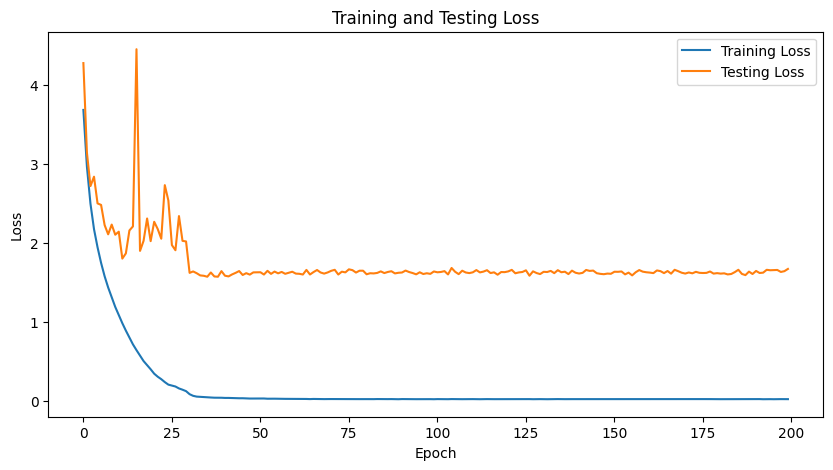

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

## Conclusion

- **Increased Convolutional Filters**: Improved feature extraction with deeper layers.
- **Added Batch Normalization**: Enhanced training stability and convergence.
- **Modified Pooling Layers**: Better spatial feature selection with additional pooling.
- **Increased Dropout Regularization**: Reduced overfitting with added dropout layers.
- **Updated Fully Connected Layers**: Enhanced capacity and stability in dense layers.
- **Overall Performance**: Achieved 66.11% accuracy on the test set, indicating significant improvements in model performance.

Test set: Average loss: 1.6720, Accuracy: 6611/10000 (66.11%)


##### Save the Final Model

In [23]:
PATH = f"model_cifar100_{groupid}"
torch.save(model, PATH)
hyperparameters = {
    'activation_fn': activation_fn,
    'batch_size': batch_size,
    'd_in': d_in,
    'd_out': d_out,
    'learning_rate': learning_rate,
    'n_epoch': 200,
}
import pickle
PATH_HYP = f"hyperparameters_cifar100"
with open(PATH_HYP, 'wb') as f:
    pickle.dump(hyperparameters, f)